# Simulating Language 8, Evolving signalling (lab) ANSWERS

This simulation implements the evolution of an innate signalling system, using the same basic signalling system code from the last labs. Make sure that you are familiar with the way in which agents and signalling systems were encoded; the same data structures are used here. 

**N.B. There's a lot of code for this lab. You might want to skim through the first part of the notebook quite quickly so you can get to the section on "Running the Simulation", and then go back and look at the code to try and understand how it works later.**

First, here's the code that we're reusing from the previous labs:

In [3]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

def wta(items):
    maxweight = max(items)
    candidates = []
    for i in range(len(items)):
        if items[i] == maxweight:
            candidates.append(i)
    return random.choice(candidates)

def communicate(speaker_system, hearer_system, meaning):
    speaker_signal = wta(speaker_system[meaning])
    hearer_meaning = wta(hearer_system[speaker_signal])
    if meaning == hearer_meaning:
        return 1
    else:
        return 0

def pop_update(population):
    speaker_index = random.randrange(len(population))
    hearer_index = random.randrange(len(population) - 1)
    if hearer_index >= speaker_index: 
        hearer_index += 1
    speaker = population[speaker_index]
    hearer = population[hearer_index]
    meaning = random.randrange(len(speaker[0]))
    success = communicate(speaker[0], hearer[1], meaning)
    speaker[2][0] += success
    speaker[2][1] += 1
    hearer[2][2] += success
    hearer[2][3] += 1

In [4]:
from copy import deepcopy

### Copying lists

The first part of the new code imports the `deepcopy` function; this is needed because of the way in which Python treats copies of lists. Have a look at the code in the example below, and see if you can guess what happens, then try it out.

```python
a = [1, 2, 3]
b = a
print(b)
a[1] = 5
print(b)
```

In [4]:
a = [1, 2, 3]
b = a
print(b)
a[1] = 5
print(b)


[1, 2, 3]
[1, 5, 3]


First, list a is created, then is ‘copied’ to b, then one of the values in a is changed. But note that the value in b is also changed!


When copying compound objects (i.e. lists), by default Python fills the new list (here: b) with references to elements in the old list (a); this means that the contents of b is actually the same as that of a, even if we change a after we ‘copied’ it.

If, instead, we want to ensure that the copied list contains new and different items, then we need to make a deep copy, using the deepcopy function from the copy module rather than simple assignment. Look at the next example to see how this works.

```python
x = [1, 2, 3]
y = deepcopy(x)
print(y)
x[1] = 5
print(y)
print(x)
```

In [6]:
x = [1, 2, 3]
y = deepcopy(x)
print(y)
x[1] = 5
print(y)
print(x)


[1, 2, 3]
[1, 2, 3]
[1, 5, 3]


### Simulation parameters

The next section defines a number of variables which are used as parameters in the simulation, with comments explaining what they are used for (anything after the hash sign (#) is a comment, and thus ignored by Python). 

We define the variables individually, and then refer to them by name in the following functions, so that when we want to run the simulation with different parameters, all we need do is either change the values here and re-run the cell, or enter new values wherever we are in the notebook and run a new simulation. 

You may find that you end up with different bits of the notebook being run out of order. This is OK, but sometimes gets a bit confusing. When I'm working with a complicated notebook, I occasionally go back to the top and simply press SHIFT+ENTER over and over to "refresh" the notebook. There's also a menu item in the "Cell" menu to run all the cells, which does the same job, but note that it will stop if it hits a cell with an error in it.

In [5]:
mutation_rate = 0.001  # probability of mutation per weight
mutation_max = 1       # maximum value of a random weight
send_weighting = 10    # weighting factor for a send score
receive_weighting = 10 # weighting factor for receive score
meanings = 3           # number of meanings
signals = 3            # number of signals
interactions = 1000    # number of interactions per generation
size = 100             # size of population

### Fitness functions

Evolutionary algorithms require a function which measures fitness and helps determine which agents will reproduce into the next generation. The two functions in the cell below define fitness for an individual agent (`fitness`) and for the whole population (`sum_fitness`); study them and see if you can figure out how they work.

In [6]:
def fitness(agent):
    send_success = agent[2][0]
    send_n = agent[2][1]
    receive_success = agent[2][2]
    receive_n = agent[2][3]
    if send_n == 0:
        send_n = 1
    if receive_n == 0:
        receive_n = 1
    return ((send_success/send_n) * send_weighting +
            (receive_success/receive_n) * receive_weighting) + 1

def sum_fitness(population):
    total = 0
    for agent in population:
        total += fitness(agent)
    return total

- Why are the variables send_n and receive_n sometimes set to 1 in the fitness function?
- What do the send_weighting and receive_weighting variables do?
- Why is there a “+1” here?

### Mutation

The next function mutates the signalling system by going through each cell in the matrix, deciding whether a mutation should take place, and, if so, assigning a new value to the cell. Note that this function contains a new random function `random.randint(x, y)`; this returns a random integer between x and y, including both x and y; `random.randint(x, y)` is therefore equivalent to `random.randrange(x, y + 1)`.

In [7]:
def mutate(system):
    for row_i in range(len(system)):
        for column_i in range(len(system[0])):
            if random.random() < mutation_rate:
                system[row_i][column_i] = random.randint(0, mutation_max)

- How does the program make sure that it goes through each cell in the matrix?
- How frequently does mutation happen?

### Breeding the next generation of agents

The next two functions create a new population of agents based on the fitness of the existing agents. The probability of being picked as a parent agent is proportional to the agent’s fitness. There is another new random function `random.uniform(x, y)`, which returns a random floating-point number between x and y; `random.uniform(0,1)` is equivalent to `random.random()`. Make sure you understand how the `pick_parent` function works - it’s quite clever, you might need paper and pencil to work it out!

In [8]:
def pick_parent(population, sum_f):
    accumulator = 0
    r = random.uniform(0, sum_f)
    for agent in population:
        accumulator += fitness(agent)
        if r < accumulator:
            return agent

def new_population(population):
    new_p = []
    sum_f = sum_fitness(population)
    for i in range(len(population)):
        parent=pick_parent(population, sum_f)
        child_production_system = deepcopy(parent[0])
        child_reception_system = deepcopy(parent[1])
        mutate(child_production_system)
        mutate(child_reception_system)
        child=[child_production_system,
               child_reception_system,
               [0., 0., 0., 0.]]
        new_p.append(child)
    return new_p

- How does the program ensure that the probability of being picked as a parent is proportional to fitness?
- Why is `deepcopy` used in `new_population`?

### Establishing a random population of agents

The function `random_system` generates a random signalling system, and this is used to generate a random population of agents (`random_population`).

In [9]:
def random_system(rows,columns):
    system = []
    for i in range(rows):
        row = []
        for j in range(columns):
            row.append(random.randint(0, mutation_max))
        system.append(row)
    return system

def random_population(size):
    population = []
    for i in range(size):
        population.append([random_system(meanings, signals),
                           random_system(signals, meanings),
                           [0., 0., 0., 0.]])
    return population

### Running the simulation (at last!)

In [10]:
def simulation(generations):
    accumulator=[]
    population = random_population(size)
    for i in range(generations):
        for j in range(interactions):
            pop_update(population)
        average_fitness=(sum_fitness(population) / size)
        accumulator.append(average_fitness)
        population = new_population(population)
    return [population, accumulator]

This function runs the main simulation. Make sure that you understand how it works, by studying the above functions again if necessary. 

You can run the simulation by typing `simulation(100)` into a cell, which will return a lot of data. Perhaps more usefully, you could do something like:

```python
my_pop, fitness_list = simulation(100)
plt.plot(fitness_list)
plt.xlabel('generations')
plt.ylabel('fitness')
plt.grid()
```

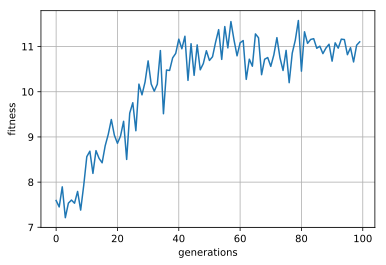

In [13]:
my_pop, fitness_list = simulation(100)
plt.plot(fitness_list)
plt.xlabel('generations')
plt.ylabel('fitness')
plt.grid()

- How often does the population communicate in each generation?
- At what point are agents assessed for fitness?
- Run the simulation for a few generations: what do values returned by simulation signify?
- Run it again, with different numbers of generations: how long does it take for a stable, successful communication system to emerge? (Note: 1000 generations takes about 10-20 seconds, so be wary of starting very very long runs)

- Now try changing one of the simulation parameters defined in the cell a few pages up (e.g. `mutation_rate`, `interactions`, `signals` etc. etc.) and running the simulation again. 

If you like, you can plot multiple runs of the simulation with different parameters on the same graph. For example:

```python
interactions = 1000
my_pop, fitness_list1 = simulation(100)

interactions = 100
my_pop, fitness_list2 = simulation(100)

plt.plot(fitness_list1, color='red', label='1000 interactions')
plt.plot(fitness_list2, color='green', label='100 interactions')
plt.xlabel('generations')
plt.ylabel('fitness')
plt.legend()
plt.grid()
```

Or, better still, you could do a bunch of runs of the simulation, and then compare them in a plot, like this (which aggregates 10 runs in each of the two paramater settings being compared):

```python
interactions = 1000
fitness_list1s = []
for n in range(10):
    my_pop, fitness_list1 = simulation(100)
    fitness_list1s.append(fitness_list1)

interactions = 100
fitness_list2s = []
for n in range(10):
    my_pop, fitness_list2 = simulation(100)
    fitness_list2s.append(fitness_list2)
    
    
for fitness_list1 in fitness_list1s:
        plt.plot(fitness_list1, color='red', alpha=0.3)
plt.plot([], color='red', label='1000 interactions')

for fitness_list2 in fitness_list2s:
        plt.plot(fitness_list2, color='green', alpha=0.3)
plt.plot([], color='green', label='100 interactions')

    
plt.xlabel('generations')
plt.ylabel('fitness')
plt.legend()
plt.grid()
```

N.B. You might want to run the simulations and plot the graphs in separate cells in the notebook, so you don't end up re-running the simulations each time you want to fiddle with the way the graphs look.

In [14]:
interactions = 1000
fitness_list1s = []
for n in range(10):
    my_pop, fitness_list1 = simulation(100)
    fitness_list1s.append(fitness_list1)

interactions = 100
fitness_list2s = []
for n in range(10):
    my_pop, fitness_list2 = simulation(100)
    fitness_list2s.append(fitness_list2)

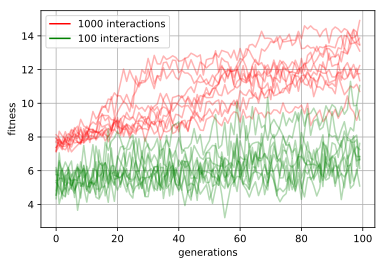

In [15]:
for fitness_list1 in fitness_list1s:
        plt.plot(fitness_list1, color='red', alpha=0.3)
plt.plot([], color='red', label='1000 interactions')

for fitness_list2 in fitness_list2s:
        plt.plot(fitness_list2, color='green', alpha=0.3)
plt.plot([], color='green', label='100 interactions')

    
plt.xlabel('generations')
plt.ylabel('fitness')
plt.legend()
plt.grid()


### Questions

Everyone should attempt questions 1 and 2, and have a think about question 4.

1. Under what conditions does stable, successful communication evolve? (Note that it is a very good idea to run the simulation a few times for each setting of the parameters you want to test, and plot the results).

In [11]:
def final_values(data):
    result=[]
    for d in data:
        result.append(d[len(d)-1])
    return result

def average_values(data):
    result=[]
    for i in range(len(data[0])):
        total = 0
        for d in data:
            total += d[i]
        result.append(total/len(data))
    return result

In [17]:
send_weighting = 20
receive_weighting = 0
data_send = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_send.append(fitness_list)
    
send_weighting = 10
receive_weighting = 10
data_mutual = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_mutual.append(fitness_list)
    
send_weighting = 0
receive_weighting = 20
data_receive = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_receive.append(fitness_list)

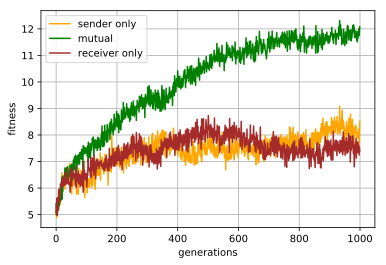

In [18]:
plt.plot(average_values(data_send), color='orange', label='sender only')
plt.plot(average_values(data_mutual), color='green', label='mutual')
plt.plot(average_values(data_receive), color='brown', label='receiver only')

plt.xlabel('generations')
plt.ylabel('fitness')
plt.legend()
plt.grid()

Text(0,0.5,'fitness')

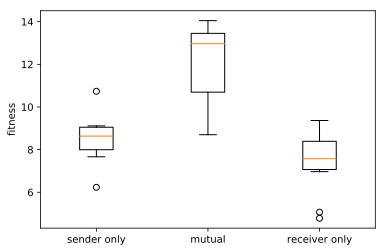

In [19]:
plt.boxplot([final_values(data_send), final_values(data_mutual), final_values(data_receive)], labels=['sender only', 'mutual', 'receiver only'])
plt.ylabel('fitness')

2. Can you speed up evolution (or slow it down)? How? Is there a limit to how fast evolution can happen in the model?

In [22]:
send_weighting = 10
receive_weighting = 10
mutation_rate = 0.0001
data_low = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_low.append(fitness_list)
    
mutation_rate = 0.001
data_medium = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_medium.append(fitness_list)
    
mutation_rate = 0.01
data_high = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_high.append(fitness_list)
    
mutation_rate = 0.1
data_very_high = []
for i in range(10):
    my_pop, fitness_list = simulation(1000)
    data_very_high.append(fitness_list)

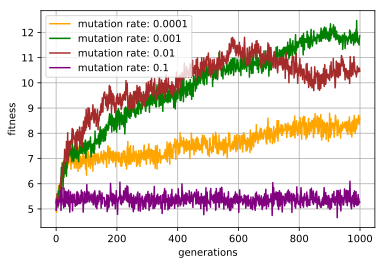

In [24]:
plt.plot(average_values(data_low), color='orange', label='mutation rate: 0.0001')
plt.plot(average_values(data_medium), color='green', label='mutation rate: 0.001')
plt.plot(average_values(data_high), color='brown', label='mutation rate: 0.01')
plt.plot(average_values(data_very_high), color='purple', label='mutation rate: 0.1')

plt.xlabel('generations')
plt.ylabel('fitness')
plt.legend()
plt.grid()

3. **[optional]** In earlier notebooks we gave you the option of modelling production and reception using a single matrix of weights, or of modelling populations in a more structured way (e.g. where each individual communicated with their neighbours). What difference do you think these factors will make to the evolution of communication? Make the necessary adjustments to the code and find out.
4. In this model a parent’s signalling system is transmitted directly to their offspring - this is our model of the genetic transmission of an innate signalling system. How else might a signalling system be transmitted from parent to offspring, and how might you model that process?

## Example answer for assessment 1

In [12]:
def initial_values(data):
    result=[]
    for d in data:
        result.append(d[0])
    return result

def count(population, type):
    c = 0
    for agent in population:
        if agent[0] == type[0] and agent[1] == type[1]:
            c += 1
    return c

def simulation2(generations, population):
    size = len(population)
    accumulator=[]
    frequency_of_mutant=[]
    for i in range(generations):
        for j in range(interactions):
            pop_update(population)
        average_fitness=(sum_fitness(population) / size)
        accumulator.append(average_fitness)
        frequency_of_mutant.append(count(population, [[[1,1],[1,1]], [[1,0],[0,1]]])/12)
        population = new_population(population)
    return [population, accumulator, frequency_of_mutant]

In [13]:
population = [[[[1, 0],[0, 1]], [[1, 0], [0, 1]], [0.,0.,0.,0.]]] * 10 + [[[[1, 1],[1, 1]], [[1, 0],[0,1]], [0.,0.,0.,0.]]] * 2

In [14]:
send_weighting=0
receive_weighting=20
mutation_rate=0
fitness_data = []
count_data = []
for i in range(100):
    my_pop, fitness_list, frequency_list = simulation2(100, population)
    fitness_data.append(fitness_list)
    count_data.append(frequency_list)


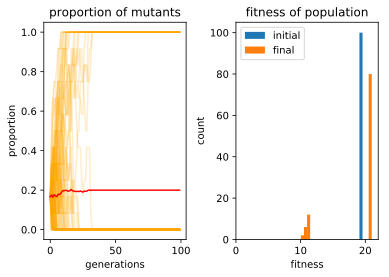

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2)


ax = axs[0]
for d in count_data:
    ax.plot(d, color='orange', alpha=0.2)

ax.plot(average_values(count_data), color='red')
ax.set_xlabel('generations')
ax.set_ylabel('proportion')
ax.set_title('proportion of mutants')


ax = axs[1]


ax.hist(initial_values(fitness_data), range=(1,21), bins=42, label='initial')

ax.hist(final_values(fitness_data), range=(1,21), bins=42, label='final')

ax.legend()
ax.set_xlabel('fitness')
ax.set_ylabel('count')
ax.set_title('fitness of population')

plt.subplots_adjust(wspace=0.35)

plt.savefig('invasion.pdf')